In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from PIL import Image
%matplotlib inline

Using TensorFlow backend.


In [2]:
img_width, img_height = 224, 224
data_dir = "./flower_photos"
batch_size = 8
epochs = 10
nb_train_samples = 3000
nb_validation_samples = 300

In [3]:
# import a model trained with Imagenet
model = keras.applications.mobilenet.MobileNet(input_shape=(img_width, img_height, 3), alpha=0.5,
                                               include_top=False, weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# Freeze the layers which you don't want to train.
for layer in model.layers:
    layer.trainable = False

In [5]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)
#model_final.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
# compile model
model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = keras.optimizers.adam(lr=0.0001),
                    metrics=["accuracy"])

In [7]:
datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

train_generator = datagen.flow_from_directory(data_dir, 
                                              target_size=(img_width, img_height), 
                                              shuffle=True, seed=13,
                                              class_mode='categorical', 
                                              batch_size=batch_size)
validation_generator = datagen.flow_from_directory(data_dir, 
                                              target_size=(img_width, img_height), 
                                              shuffle=True, seed=13,
                                              class_mode='categorical', 
                                              batch_size=batch_size)

Found 3670 images belonging to 5 classes.
Found 3670 images belonging to 5 classes.


In [8]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("transfer_mobilenet_split.h5", monitor='val_acc', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [9]:
# Train the model 
model_final.fit_generator(
    train_generator,
    epochs = 2,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples,
    callbacks = [checkpoint, early],
    steps_per_epoch=375)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
375/375 [==============================] - 125s 334ms/step - loss: 1.4557 - acc: 0.4823 - val_loss: 0.9714 - val_acc: 0.5804

Epoch 00001: val_acc improved from -inf to 0.58042, saving model to transfer_mobilenet_split.h5
Epoch 2/2
375/375 [==============================] - 125s 333ms/step - loss: 1.0086 - acc: 0.6124 - val_loss: 0.9445 - val_acc: 0.6514

Epoch 00002: val_acc improved from 0.58042 to 0.65138, saving model to transfer_mobilenet_split.h5


In [15]:
from keras.utils.generic_utils import CustomObjectScope
from keras import models
from keras.applications import MobileNet

with CustomObjectScope({'relu6': keras.layers.ReLU(6.),'DepthwiseConv2D': keras.layers.DepthwiseConv2D}):
    model_final = load_model('transfer_mobilenet_split.h5')
    

(224, 224, 3)


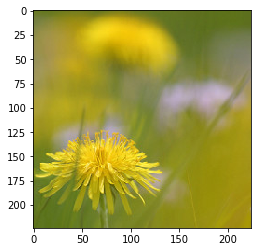

In [16]:
#IM = Image.open(data_dir + '/sunflowers/20407896403_a50fef58ac_n.jpg')
#IM = Image.open(data_dir + '/daisy/2641151167_3bf1349606_m.jpg')
#IM = Image.open(data_dir + '/tulips/3150964108_24dbec4b23_m.jpg')
#IM = Image.open(data_dir + '/roses/3634244527_e72c47842c_n.jpg')
IM = Image.open(data_dir + '/dandelion/14060367700_fe87e99b6a_m.jpg')

npim = np.array(IM.resize((img_height, img_width), Image.NEAREST))
print(npim.shape)
plt.imshow(npim)
npim = npim.reshape((1,img_height, img_width,3))/255.0

[4.3397337e-01 4.7169167e-01 1.3254504e-04 9.3553767e-02 6.4870005e-04]


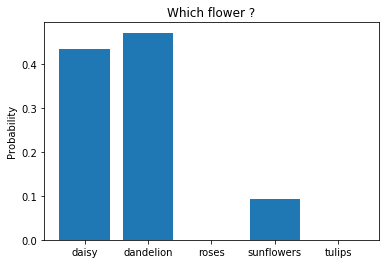

In [17]:
prob = model_final.predict(npim)
print(prob[0,:])
labels = ('daisy', 'dandelion', 'roses', 'sunflowers', 'tulips')
y_pos = np.arange(len(labels))
plt.bar(y_pos, prob[0,:])
plt.xticks(y_pos, labels)
plt.ylabel('Probability')
plt.title('Which flower ?')
 
plt.show()